In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


from IPython.display import display, HTML, Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import make_scorer
from sklearn import metrics

# to avoid future warnings for sklearn
import warnings
warnings.filterwarnings("ignore")



In [2]:
from pymongo import MongoClient
connection=MongoClient("mongodb://localhost:27017/crawler.contents")

db=connection.get_database()
articles = pd.DataFrame(list(db.contents.find()))
articles = articles.drop(columns=['visited','alternateImageUrl','created_at','contentType','date','icon','publishedAt','source','url'])
articles = articles.sample(frac=1).reset_index(drop=True)

In [3]:
classes = list(set(articles.classes_target.dropna().values.sum()))

In [4]:
df = pd.concat([articles,articles['classes_target'].fillna("").map(lambda x: ",".join(x)).str.get_dummies(sep=",")],axis=1)
counts = []
for i in classes:
    counts.append((i,df[i].sum()))


In [5]:
stats = pd.DataFrame(counts, columns=['cat','count'])

In [6]:
stats

,cat,count
0,USD,19259
1,OIL,1988
2,XAU,1446
3,CNY,1522
4,TWD,72
5,INDEX,10092
6,BTC,1096
7,NZD,2953
8,JPY,6399
9,CHF,1600


Text(0.5, 0, 'category')

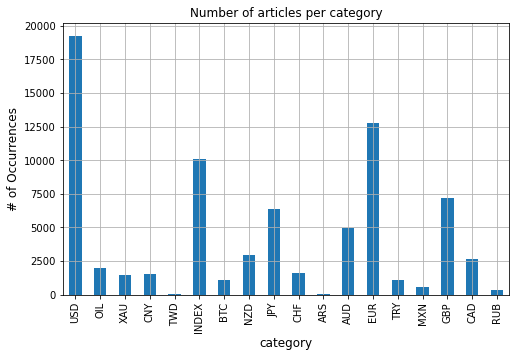

In [7]:
stats.plot(x='cat', y='count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of articles per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

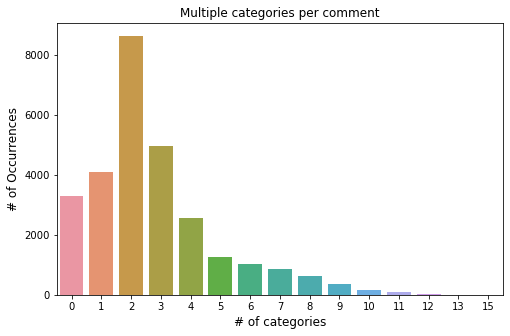

In [8]:
import seaborn as sns
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [9]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['classes_target'].str.len()==0)]) / len(df))

Percentage of comments that are not labelled:
0.09466671442386905


<AxesSubplot:>

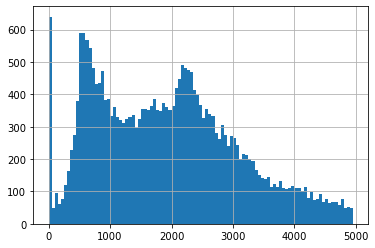

In [10]:
lens = df.body.dropna().map(lambda x: " ".join(x)).str.len()
lens.hist(bins = np.arange(0,5000,50))

In [11]:
def clean_text(txt):
    txt = re.sub(r'\d+ min read', '', str(txt), flags=re.IGNORECASE)
    txt = re.sub(r'by reuters staff', '', str(txt), flags=re.IGNORECASE)
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt   
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### stemming (remove -ing, -ly, ...)
    
    ps = nltk.stem.porter.PorterStemmer()
    lst_txt = [ps.stem(word) for word in lst_txt]
    ### lemmatization (convert the word into root word)
    
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_txt = [lem.lemmatize(word) for word in lst_txt]
    
    lst_txt = [word for word in lst_txt if word not in 
               lst_stopwords]
    ### back to string
    txt = " ".join(lst_txt)
    return txt
    

In [12]:
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=LogisticRegression()):
        self.base_classifier=base_classifier

    def fit(self, X, y):
        """Build a Binary Relevance classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples, n_labels] 
            The target values (class labels) as integers or strings.
        """

        # list of individual classifiers
        self.models = []
       
        # for every class label
        for label in list(y.columns):
            # Check that X and y have correct shape
            x_checked, y_checked = check_X_y(X, y[label])
            # every classifier is independent of the others
            # hence we create a copy of the base classifier instance
            base_model = clone(self.base_classifier)
            # fit the base model - one model each for Y1, Y2....Y14
            basel_model = base_model.fit(x_checked, y_checked)
            # add the fitted model list of individual classifiers
            self.models.append(base_model)

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        X = check_array(X)
        
        all_preds = pd.DataFrame()
        i=0
        # list of individual classifier predictions
        preds = []
        
        # predict against each fitted model - one model per label
        for model in self.models:
            pred = model.predict(X)
            # add the prediction to the dataframe
            preds.append(pd.DataFrame({'Class'+ str(i+1): pred}))
            i+=1
        
        # dataframe with predictions for all class labels
        all_preds = pd.concat(preds, axis=1)
        # standard sklearn classifiers return predictions as numpy arrays
        # hence convert the dataframe to a numpy array
        return all_preds.to_numpy()
    


    def predict_proba(self,X):
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        X = check_array(X)
        
        all_preds = pd.DataFrame()
        i = 0
        
        for model in self.models:
            # Call predict_proba of the each base model
            pred = model.predict_proba(X)
            # Add the probabilities of 1 to the dataframe
            all_preds['Class'+str(i+1)] = [one_prob[1] for one_prob in pred]
            i+=1
        
        #return probabilities
        return all_preds.to_numpy()

In [13]:
def accuracy_score(y_test, y_pred):
    # y_pred is a numpy array, y_test is a dataframe
    # to compare the two, convert to a single type
    y_test = y_test.to_numpy()
    
    # shape of test and preds must be equal
    assert y_test.shape == y_pred.shape
    i=0
    # list of scores for each training sample
    scores = []
    
    # for each test sample
    while i < len(y_test):
        count=0
        # count the number of matches in the sample
        # y_test[i] -> row values in test set (true values)
        # y_pred[i] -> row values in predictions set (predicted values)
        for p, q in zip(y_test[i], y_pred[i]):
            if p == q:
                count += 1

        # accuracy score for the sample = no. of correctly predicted labels/total no. of labels
        scores.append(count / y_pred.shape[1])
        i+=1 

    # final accuracy = avg. accuracy over all test samples =
    # sum of the accuracy of all training samples/no. of training samples
    return round((sum(scores)/len(y_test)), 5)

In [14]:
class BinaryRelevanceClassifierUS(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=LogisticRegression(max_iter=20000)):
        self.base_classifier=base_classifier

    def fit(self, X, y):
        """Build a Binary Relevance classifier with Under sampling from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        """

        # list of individual classifiers
        self.models = []
        
        # for each class label
        for label in list(y.columns):
            
            X_cp = X.copy()
            # pick the column values for the label
            y_cp = y[label]
            
            # sampling is done on both X and y, hence join the two dataframes
            X_y_data = pd.concat([X_cp, y_cp], axis=1)
            
            # counters for 0 values and 1 values
            n_val0, n_val1 = 0,0
            
            j=0
            # for each sample
            while j<len(X_y_data):
                # if value for the label is 0
                if(X_y_data.iloc[j][label] == 0):
                    n_val0+=1
                else:
                    # value 1
                    n_val1+=1
                j+=1
            
            # under sample the majority class
            # randomly pick samples from majority class equal to the number of samples in the minority class
            # both the classes will have the same number of samples
            if n_val0 > n_val1:
                # majority 0 values
                val1 = X_y_data[X_y_data[label]==1]
                val0 = X_y_data[X_y_data[label]==0].sample(n_val1)
                
                X_y_data = pd.concat([val0, val1], axis=0)
            
            elif n_val1 > n_val0:
                # majority 1 values
                val1 = X_y_data[X_y_data[label]==1].sample(n_val0)
                val0 = X_y_data[X_y_data[label]==0]
                
                X_y_data = pd.concat([val0, val1], axis=0)
            
            # split back into X and y
            X_cp = X_y_data.iloc[:, :-1]
            y_cp = X_y_data.iloc[:, -1]
            
            base_model = clone(self.base_classifier)
            # fit the base model - one model each for Y1, Y2....Y14
            a, b = check_X_y(X_cp, y_cp)
            base_model.fit(a, b)
            # list of individual classifiers classifiers
            self.models.append(base_model)


    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        X = check_array(X)
        
        all_preds = pd.DataFrame()
        i=0
        # list of individual classifier predictions
        preds = []
        
        # for every fitted model
        for model in self.models:
            # predict for X
            pred = model.predict(X)
            # add to the list of predictions
            preds.append(pd.DataFrame({'Class'+ str(i+1): pred}))
            i+=1
        
        # store predictions for each label in a single dataframe
        all_preds = pd.concat(preds, axis=1)
        # standard sklearn classifiers return predictions as numpy arrays
        # hence convert the dataframe to a numpy array
        return all_preds.to_numpy()
    
    
    def predict_proba(self,X):
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        X = check_array(X)
        
        all_preds = pd.DataFrame()
        i = 0
        
        for model in self.models:
            # Call predict_proba of the each base model
            pred = model.predict_proba(X)
            # Add the probabilities of 1 to the dataframe
            all_preds['Class'+str(i+1)] = [one_prob[1] for one_prob in pred]
            i+=1
        
        #return probabilities
        return all_preds.to_numpy()

In [66]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=LogisticRegression(max_iter=20000), order=None, classes=None):
        self.base_classifier=base_classifier
        self.order = order
        self.classes = classes

    def fit(self, X, y):
        """
        Build a Classifier Chain from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples, n_labels] 
            The target values (class labels) as integers or strings.

        """
        
        # check the order parameter
        if self.order is None:
            # default value - natural order for number of labels
            self.order = list(range(y.shape[1]))
        elif self.order == 'random':
            # random order
            self.order = list(range(y.shape[1]))
            random.shuffle(self.order)
        else:
            # order specified
            if(len(self.order)==y.shape[1]):
                # expect order from 1, hence reduce 1 to consider zero indexing
                self.order = [o - 1 for o in self.order]
    
        
        # list of base models for each class
        self.models = [clone(self.base_classifier) for clf in range(y.shape[1])]

        # create a copy of X
        X_joined = X.copy()
       # X_joined.reset_index(drop=True, inplace=True)
        
        # create a new dataframe with X and y-in the order specified
        # if order = [2,4,5,6...] -> X_joined= X, y2, y4, y5...
        for val in self.order:
            X_joined = pd.concat([X_joined, y[self.classes[val]]], axis=1)

        
        # for each ith model, fit the model on X + y0 to yi-1 (in the order specified)
        # if order = [2,4,6,....] fit 1st model on X for y2, fit second model on X+y2 for y4...
        for chain_index, model in enumerate(self.models):
            # select values of the class in order
            y_vals = y.loc[:, self.classes[self.order[chain_index]]]
            # pick values for training - X+y upto the current label
            t_X = X_joined.iloc[:, :(X.shape[1]+chain_index)]
            check_X_y(t_X, y_vals)
            # fit the model
            model.fit(t_X, y_vals)


            
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        
        # dataframe to maintain previous predictions
        pred_chain = pd.DataFrame(columns=[self.classes[o] for o in self.order])
        
        X_copy = X.copy()
        X_joined = X.copy()
        
        # use default indexing
        X_joined.reset_index(drop=True, inplace=True)
        X_copy.reset_index(drop=True, inplace=True)

        i=0
        
        # for each ith model, predict based on X + predictions of all models upto i-1
        # happens in the specified order since models are already fitted according to the order
        for chain_index, model in enumerate(self.models):
            # select previous predictions - all columns upto the current index
            prev_preds = pred_chain.iloc[:, :chain_index]
            # join the previous predictions with X
            X_joined = pd.concat([X_copy, prev_preds], axis=1)
            # predict on the base model
            pred = model.predict(X_joined)
            # add the new prediction to the pred chain
            pred_chain[self.classes[self.order[i]]] = pred
            i+=1

        # re-arrange the columns in natural order to return the predictions
        pred_chain = pred_chain.loc[:, [self.classes[j] for j in range(0, len(self.order))]]
        # all sklearn implementations return numpy array
        # hence convert the dataframe to numpy array
        return pred_chain.to_numpy()
    
    
    
    # Function to predict probabilities of 1s
    def predict_proba(self, X):
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        
        # dataframe to maintain previous predictions
        pred_chain = pd.DataFrame(columns=[self.classes[o] for o in self.order])
        # dataframe to maintain probabilities of class labels
        pred_probs = pd.DataFrame(columns=[self.classes[o] for o in self.order])
        X_copy = X.copy()
        X_joined = X.copy()
        
        # use default indexing
        X_joined.reset_index(drop=True, inplace=True)
        X_copy.reset_index(drop=True, inplace=True)

        i=0
        
        # for each ith model, predict based on X + predictions of all models upto i-1
        # happens in the specified order since models are already fitted according to the order
        for chain_index, model in enumerate(self.models):
            
            # select previous predictions - all columns upto the current index
            prev_preds = pred_chain.iloc[:, :chain_index]
            # join the previous predictions with X
            X_joined = pd.concat([X_copy, prev_preds], axis=1)
            # predict on the base model
            pred = model.predict(X_joined)
            # predict probabilities
            pred_proba = model.predict_proba(X_joined)
            # add the new prediction to the pred chain
            pred_chain[self.classes[self.order[i]]] = pred
            # save the probabilities of 1 according to label order
            pred_probs[self.classes[self.order[i]]] = [one_prob[1] for one_prob in pred_proba]
            i+=1

        # re-arrange the columns in natural order to return the probabilities
        pred_probs = pred_probs.loc[:, [self.classes[j] for j in range(0, len(self.order))]]
        # all sklearn implementations return numpy array
        # hence convert the dataframe to numpy array
        return pred_probs.to_numpy()

In [16]:

to_remove = ['ARS','MXN','OIL','XAU','TRY','INDEX','BTC','TWD','RUB','CHF']
df = df.drop(labels=to_remove,axis=1)
classes = [cls for cls in classes if cls not in to_remove]
df['text_clean'] = df.body.map(lambda x: " ".join(list(x)) if type(x) is list else "" ).map(lambda com : clean_text(com))

In [17]:
df[classes].sum(axis=1)
df = df.sample(n=3000)
train, test = train_test_split(df[(df[classes].sum(axis=1)>0)], random_state=42, test_size=0.50, shuffle=True)

In [18]:
# NB_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(MultinomialNB(
#                     fit_prior=True, class_prior=None))),
#             ])
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     NB_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = NB_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
#     print('Balanced Test accuracy is {}'.format(balanced_accuracy_score(test[category], prediction)))

In [19]:
# LogReg_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
#             ])
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     LogReg_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

In [20]:
# SVC_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
#             ])
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     SVC_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = SVC_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

In [21]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(train.text_clean)


TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [22]:
# # using classifier chains
# from skmultilearn.problem_transform import ClassifierChain
# from sklearn.linear_model import LogisticRegression# initialize classifier chains multi-label classifier
# classifier = ClassifierChain(LogisticRegression())# Training logistic regression model on train data
# classifier.fit(x, y)# predict
# predictions = classifier.predict(vectorizer.transform(X_test))# accuracy
# print("Accuracy = ",accuracy_score(test.drop(labels=['_id','summary','body','text_clean','classes_target','classes_body','classes_summary','classes_title','title'],axis=1),predictions))
# print("\n")

In [23]:
# n =400
# listdf = [train[i:i+n] for i in range(0,train.shape[0],n)]

# from skmultilearn.problem_transform import BinaryRelevance
# from sklearn.naive_bayes import GaussianNB# initialize binary relevance multi-label classifier
# # with a gaussian naive bayes base classifier
# classifier = BinaryRelevance(GaussianNB())# train
# # classifier.fit(x_train, y_train)# predict
# # predictions = classifier.predict(x_test)# accuracy
# # print("Accuracy = ",accuracy_score(y_test,predictions))

In [24]:
# for x in listdf:
#     X_train = vectorizer.transform(x.text_clean)
#     y_train = x.drop(labels=['_id','summary','body','text_clean','classes_target','classes_body','classes_summary','classes_title','title'],axis=1)
#     classifier.fit(X_train,y_train)

In [25]:
# listdf = [test[i:i+n] for i in range(0,test.shape[0],n)]
# predictions = []
# for x in listdf:
#     predictions.append(classifier.predict(vectorizer.transform(x.text_clean)))

In [26]:
# ee = [item[0].toarray()[0] for sub_list in predictions for item in sub_list]

In [27]:
# instantiate the classifier
br_clf = BinaryRelevanceClassifier(LogisticRegression())
# fit
br_clf.fit(vectorizer.transform(train.text_clean).toarray(), train[classes])
# predict


In [28]:
y_pred = br_clf.predict(vectorizer.transform(test.text_clean).toarray())

In [29]:
print("y_pred.shape: " + str(y_pred.shape))

y_pred.shape: (1189, 8)


In [30]:
print("Accuracy of Binary Relevance Classifier: " + str(accuracy_score(test[classes], y_pred)))

Accuracy of Binary Relevance Classifier: 0.86638


In [31]:
X_train = vectorizer.transform(train.text_clean).toarray()
y_train = train[classes]

In [32]:
cv_folds=5

# Set up the parameter grid to search
param_grid ={'base_classifier': [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
                                 RandomForestClassifier(criterion='entropy'),
                                 LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()] }

# Perform the search
# Using the custom accuracy function defined earlier
tuned_model = GridSearchCV(BinaryRelevanceClassifier(), \
                            param_grid, scoring=make_scorer(accuracy_score), verbose = 2, cv=cv_folds)
tuned_model.fit(X_train, y_train)

# Print details of the best model
print("Best Parameters Found: ")
display(tuned_model.best_params_)
display(tuned_model.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total=   7.8s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total=   9.0s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total=   9.2s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total=   8.4s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total=   7.9s
[CV] base_classifier=RandomForestClassifier(criterion='entropy') .....
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), total=  23.4s
[CV] base_classifier=RandomForestClassifier(criterion='entropy') .....
[CV]  base_classi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 20.1min finished


Best Parameters Found: 


{'base_classifier': DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2)}

0.9756939999999998

In [41]:
class BinaryRelevanceClassifierUS(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=LogisticRegression(max_iter=20000)):
        self.base_classifier=base_classifier

    def fit(self, X, y):
        """Build a Binary Relevance classifier with Under sampling from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        """

        # list of individual classifiers
        self.models = []
        
        # for each class label
        for label in list(y.columns):
            
            X_cp = X.copy()
            # pick the column values for the label
            y_cp = y[label]
            
            # sampling is done on both X and y, hence join the two dataframes
            X_y_data = pd.concat([X_cp, y_cp], axis=1)
            
            # counters for 0 values and 1 values
            n_val0, n_val1 = 0,0
            
            j=0
            # for each sample
            while j<len(X_y_data):
                # if value for the label is 0
                if(X_y_data.iloc[j][label] == 0):
                    n_val0+=1
                else:
                    # value 1
                    n_val1+=1
                j+=1
            
            # under sample the majority class
            # randomly pick samples from majority class equal to the number of samples in the minority class
            # both the classes will have the same number of samples
            if n_val0 > n_val1:
                # majority 0 values
                val1 = X_y_data[X_y_data[label]==1]
                val0 = X_y_data[X_y_data[label]==0].sample(n_val1).reset_index(drop=True)
                
                X_y_data = pd.concat([val0, val1], axis=0)
            
            elif n_val1 > n_val0:
                # majority 1 values
                val1 = X_y_data[X_y_data[label]==1].sample(n_val0).reset_index(drop=True)
                val0 = X_y_data[X_y_data[label]==0]
                
                X_y_data = pd.concat([val0, val1], axis=0)
            
            # split back into X and y
            X_cp = X_y_data.iloc[:, :-1]
            y_cp = X_y_data.iloc[:, -1]
            
            base_model = clone(self.base_classifier)
            # fit the base model - one model each for Y1, Y2....Y14
            a, b = check_X_y(X_cp, y_cp)
            base_model.fit(a, b)
            # list of individual classifiers classifiers
            self.models.append(base_model)


    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        X = check_array(X)
        
        all_preds = pd.DataFrame()
        i=0
        # list of individual classifier predictions
        preds = []
        
        # for every fitted model
        for model in self.models:
            # predict for X
            pred = model.predict(X)
            # add to the list of predictions
            preds.append(pd.DataFrame({'Class'+ str(i+1): pred}))
            i+=1
        
        # store predictions for each label in a single dataframe
        all_preds = pd.concat(preds, axis=1)
        # standard sklearn classifiers return predictions as numpy arrays
        # hence convert the dataframe to a numpy array
        return all_preds.to_numpy()
    
    
    def predict_proba(self,X):
        # check if the models list has been set up
        check_is_fitted(self, ['models'])
        X = check_array(X)
        
        all_preds = pd.DataFrame()
        i = 0
        
        for model in self.models:
            # Call predict_proba of the each base model
            pred = model.predict_proba(X)
            # Add the probabilities of 1 to the dataframe
            all_preds['Class'+str(i+1)] = [one_prob[1] for one_prob in pred]
            i+=1
        
        #return probabilities
        return all_preds.to_numpy()


In [42]:
brus_clf = BinaryRelevanceClassifierUS()
train = train.reset_index()
# .
brus_clf.fit(pd.DataFrame(vectorizer.transform(train.text_clean).toarray()), train[classes])

# predict br_clf.fit(vectorizer.transform(train.text_clean).toarray(), train[classes])
y_pred = brus_clf.predict(vectorizer.transform(test.text_clean).toarray())
print("y_pred.shape=" + str(y_pred.shape))

y_pred.shape=(1189, 8)


In [43]:
print("Accuracy of Binary Relevance Classifier with Under-sampling: " + str(accuracy_score(test[classes], y_pred)))

Accuracy of Binary Relevance Classifier with Under-sampling: 0.87079


In [44]:
cv_folds=5

# Set up the parameter grid to search
param_grid ={'base_classifier': [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
                                 RandomForestClassifier(criterion='entropy'),
                                 LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()] }

# Perform the search
# Using the custom accuracy function defined earlier
tuned_model = GridSearchCV(BinaryRelevanceClassifierUS(), \
                            param_grid, scoring=make_scorer(accuracy_score), verbose = 2, cv=cv_folds)
tuned_model.fit(pd.DataFrame(vectorizer.transform(train.text_clean).toarray()), train[classes])

# Print details of the best model
print("Best Parameters Found: ")
display(tuned_model.best_params_)
display(tuned_model.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total= 1.5min
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total= 1.2min
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total= 1.1min
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total= 1.2min
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2) 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), total= 1.2min
[CV] base_classifier=RandomForestClassifier(criterion='entropy') .....
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), total= 1.4min
[CV] base_classifier=RandomForestClassifier(criterion='entropy') .....
[CV]  base_classi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 42.2min finished


Best Parameters Found: 


{'base_classifier': DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2)}

0.969064

In [52]:
# list of base models
X_train = pd.DataFrame(vectorizer.transform(train.text_clean).toarray())
y_train = train[classes]
X_test = pd.DataFrame(vectorizer.transform(test.text_clean).toarray())
y_test = test[classes]
base_models = [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
               RandomForestClassifier(criterion='entropy'),
               LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()]
base_model_names = ["Decision Tree", "Random Forest", "Logistic Regression", "GaussianNB", "kNN", "SVM"]

# store accuracy scores
br_clf_accuracies = dict()
br_clfus_accuracies = dict()

# store F1 scores
br_clf_f1 = dict()
br_clfus_f1 = dict()

i=0
for clf in base_models:
    # without undersampling
    br_clf = BinaryRelevanceClassifier(clf)
    br_clf.fit(X_train, y_train)
    br_y_pred = br_clf.predict(X_test)

    # find accuracy using custom accuracy function defined
    accuracy = accuracy_score(y_test, br_y_pred)
    br_clf_accuracies[base_model_names[i]] = accuracy

    # find f1 score using sklearn
    y_pred_df = pd.DataFrame(br_y_pred)
    f1_score_br = metrics.f1_score(y_test, y_pred_df, average='macro')
    br_clf_f1[base_model_names[i]] = f1_score_br

    
    # with undersampling
    brus_clf = BinaryRelevanceClassifierUS(clf)
    brus_clf.fit(X_train, y_train)
    brus_y_pred = brus_clf.predict(X_test)
    
    # find accuracy using custom accuracy function defined
    accuracy_us = accuracy_score(y_test, brus_y_pred)
    br_clfus_accuracies[base_model_names[i]] = accuracy_us
    
    # find f1 score using sklearn
    y_pred_df = pd.DataFrame(brus_y_pred)
    f1_score_us = metrics.f1_score(y_test, y_pred_df, average='macro')
    br_clfus_f1[base_model_names[i]] = f1_score_us
    
    i+=1

print("===================Accuracy Scores=====================")
print("Binary Relevance")
display(br_clf_accuracies)
print("Binary Relevance with Under-Sampling")
display(br_clfus_accuracies)

print("======================F1 Scores========================")
print("Binary Relevance")
display(br_clf_f1)
print("Binary Relevance with Under-Sampling")
display(br_clfus_f1)

===================Accuracy Scores=====================
Binary Relevance


{'Decision Tree': 0.9795,
 'Random Forest': 0.89193,
 'Logistic Regression': 0.86638,
 'GaussianNB': 0.78932,
 'kNN': 0.78837,
 'SVM': 0.88415}

Binary Relevance with Under-Sampling


{'Decision Tree': 0.96857,
 'Random Forest': 0.87479,
 'Logistic Regression': 0.86922,
 'GaussianNB': 0.54804,
 'kNN': 0.75116,
 'SVM': 0.86848}

======================F1 Scores========================
Binary Relevance


{'Decision Tree': 0.9558818840533707,
 'Random Forest': 0.5977766529696773,
 'Logistic Regression': 0.519950113487461,
 'GaussianNB': 0.4574206039387385,
 'kNN': 0.2539281510330755,
 'SVM': 0.6531965054453861}

Binary Relevance with Under-Sampling


{'Decision Tree': 0.9389072601246716,
 'Random Forest': 0.7385887978167425,
 'Logistic Regression': 0.7359806737076211,
 'GaussianNB': 0.4818425592700376,
 'kNN': 0.4093683865549765,
 'SVM': 0.7350920071944542}

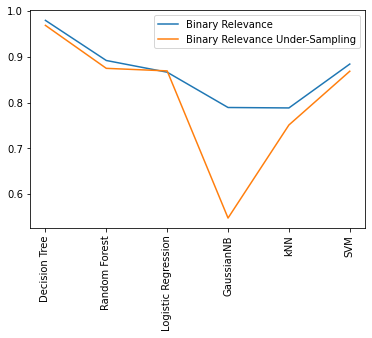

In [53]:
plt.plot(list(br_clf_accuracies.keys()), list(br_clf_accuracies.values()))
plt.plot(list(br_clfus_accuracies.keys()), list(br_clfus_accuracies.values()))
plt.xticks(rotation=90)
plt.legend(['Binary Relevance','Binary Relevance Under-Sampling'])

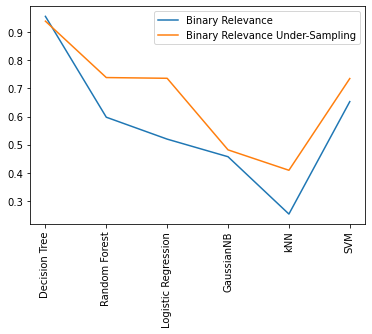

In [54]:
plt.plot(list(br_clf_f1.keys()), list(br_clf_f1.values()))
plt.plot(list(br_clfus_f1.keys()), list(br_clfus_f1.values()))
plt.xticks(rotation=90)
plt.legend(['Binary Relevance','Binary Relevance Under-Sampling'])

In [67]:
cc = ClassifierChains(classes=classes)
# fit
cc.fit(X_train, y_train)

In [68]:
cc_pred = cc.predict(X_test)
print(cc_pred.shape)
print(y_test.shape)
print(y_train.shape)

(1189, 8)
(1189, 8)
(1188, 8)


In [69]:
print("Accuracy of Classifier Chains: " + str(accuracy_score(test[classes], cc_pred)))

Accuracy of Classifier Chains: 0.84998


In [74]:
cv_folds=5

# generate 20 random orders for class labels 
rand_orders = [list(range(0, y_test.shape[1])) for i in list(range(1, 20))]

for lst in rand_orders:
    random.shuffle(lst)

# make sure natural order is present
rand_orders.append([0,1,2,3,4,5,6,7])

# Set up the parameter grid to search
param_grid ={'base_classifier': [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
                                 RandomForestClassifier(criterion='entropy'),
                                 LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()],
            'order': rand_orders,}

# Perform the search
tuned_model = GridSearchCV(ClassifierChains(classes=classes), \
                            param_grid, scoring=make_scorer(accuracy_score), verbose = 2, cv=cv_folds)
tuned_model.fit(X_train, y_train)

# Print details
print("Best Parameters Found: ")
display(tuned_model.best_params_)
display(tuned_model.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  15.0s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0] 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  13.0s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  10.1s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  10.3s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  10.2s
[CV] base_classi

[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[3, 1, 0, 2, 5, 4, 7, 6], total=   9.0s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[3, 1, 0, 2, 5, 4, 7, 6] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[3, 1, 0, 2, 5, 4, 7, 6], total=   8.8s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[3, 1, 0, 2, 5, 4, 7, 6] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[3, 1, 0, 2, 5, 4, 7, 6], total=   8.2s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[3, 1, 0, 2, 5, 4, 7, 6] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[3, 1, 0, 2, 5, 4, 7, 6], total=   8.0s
[CV] base_classi

[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[7, 4, 2, 0, 1, 6, 5, 3], total=   7.5s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[7, 4, 2, 0, 1, 6, 5, 3] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[7, 4, 2, 0, 1, 6, 5, 3], total=   8.7s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[7, 4, 2, 0, 1, 6, 5, 3] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[7, 4, 2, 0, 1, 6, 5, 3], total=   9.4s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[7, 4, 2, 0, 1, 6, 5, 3] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[7, 4, 2, 0, 1, 6, 5, 3], total=   9.5s
[CV] base_classi

[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[0, 5, 4, 6, 3, 7, 1, 2], total=   6.3s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[0, 5, 4, 6, 3, 7, 1, 2] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[0, 5, 4, 6, 3, 7, 1, 2], total=   7.1s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[0, 5, 4, 6, 3, 7, 1, 2] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[0, 5, 4, 6, 3, 7, 1, 2], total=   6.8s
[CV] base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[0, 5, 4, 6, 3, 7, 1, 2] 
[CV]  base_classifier=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2), order=[0, 5, 4, 6, 3, 7, 1, 2], total=   7.1s
[CV] base_classi

[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[0, 7, 6, 1, 2, 3, 4, 5], total=  18.5s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[0, 7, 6, 1, 2, 3, 4, 5] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[0, 7, 6, 1, 2, 3, 4, 5], total=  17.0s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[3, 1, 0, 2, 5, 4, 7, 6] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[3, 1, 0, 2, 5, 4, 7, 6], total=  16.9s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[3, 1, 0, 2, 5, 4, 7, 6] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[3, 1, 0, 2, 5, 4, 7, 6], total=  15.7s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[3, 1, 0, 2, 5, 4, 7, 6] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[3, 1, 0, 2, 5, 4, 7, 6], total=  18.1s
[CV] base_classifier=RandomForestClassifier

[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 5, 7, 1, 2, 0, 3, 4], total=  13.6s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 5, 7, 1, 2, 0, 3, 4] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 5, 7, 1, 2, 0, 3, 4], total=  15.1s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 5, 7, 1, 2, 0, 3, 4] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 5, 7, 1, 2, 0, 3, 4], total=  13.7s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 7, 5, 0, 3, 2, 1, 4] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 7, 5, 0, 3, 2, 1, 4], total=  14.9s
[CV] base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 7, 5, 0, 3, 2, 1, 4] 
[CV]  base_classifier=RandomForestClassifier(criterion='entropy'), order=[6, 7, 5, 0, 3, 2, 1, 4], total=  14.1s
[CV] base_classifier=RandomForestClassifier

[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[1, 0, 7, 4, 3, 5, 2, 6], total=  10.9s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[1, 0, 7, 4, 3, 5, 2, 6] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[1, 0, 7, 4, 3, 5, 2, 6], total=  10.2s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[1, 0, 7, 4, 3, 5, 2, 6] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[1, 0, 7, 4, 3, 5, 2, 6], total=  11.4s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[2, 7, 0, 3, 1, 4, 5, 6] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[2, 7, 0, 3, 1, 4, 5, 6], total=  10.1s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[2, 7, 0, 3, 1, 4, 5, 6] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[2, 7, 0, 3, 1, 4, 5, 6], total=  11.2s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[2, 7, 0, 3, 1, 4, 5, 6] 
[CV]  base_classifier=LogisticRegre

[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  10.1s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  11.2s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  10.1s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  11.1s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  10.7s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[7, 2, 1, 4, 0, 6, 3, 5] 
[CV]  base_classifier=LogisticRegre

[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[0, 5, 4, 6, 3, 7, 1, 2], total=  11.8s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[0, 5, 4, 6, 3, 7, 1, 2] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[0, 5, 4, 6, 3, 7, 1, 2], total=  10.1s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[0, 1, 2, 3, 4, 5, 6, 7] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[0, 1, 2, 3, 4, 5, 6, 7], total=  11.0s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[0, 1, 2, 3, 4, 5, 6, 7] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[0, 1, 2, 3, 4, 5, 6, 7], total=   9.9s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[0, 1, 2, 3, 4, 5, 6, 7] 
[CV]  base_classifier=LogisticRegression(max_iter=20000), order=[0, 1, 2, 3, 4, 5, 6, 7], total=  10.2s
[CV] base_classifier=LogisticRegression(max_iter=20000), order=[0, 1, 2, 3, 4, 5, 6, 7] 
[CV]  base_classifier=LogisticRegre

[CV]  base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3], total=   6.9s
[CV] base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3] ....
[CV]  base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3], total=   7.4s
[CV] base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3] ....
[CV]  base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3], total=   6.8s
[CV] base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3] ....
[CV]  base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3], total=   6.8s
[CV] base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3] ....
[CV]  base_classifier=GaussianNB(), order=[7, 2, 5, 0, 4, 1, 6, 3], total=   7.0s
[CV] base_classifier=GaussianNB(), order=[6, 7, 1, 4, 5, 3, 0, 2] ....
[CV]  base_classifier=GaussianNB(), order=[6, 7, 1, 4, 5, 3, 0, 2], total=   7.8s
[CV] base_classifier=GaussianNB(), order=[6, 7, 1, 4, 5, 3, 0, 2] ....
[CV]  base_classifier=GaussianNB(), order=[6, 7, 1, 4, 5, 3, 0, 2], total=   6.9s


[CV]  base_classifier=GaussianNB(), order=[0, 1, 2, 3, 4, 5, 6, 7], total=   6.4s
[CV] base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  53.2s
[CV] base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  49.6s
[CV] base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  49.7s
[CV] base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  47.3s
[CV] base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0] 
[CV]  base_classifier=KNeighborsClassifier(), order=[4, 6, 7, 2, 1, 5, 3, 0], total=  49.8s
[CV] base_classifier=KNeighborsClassifier(), order=[1, 0, 7, 4, 3, 5, 2, 

[CV]  base_classifier=KNeighborsClassifier(), order=[7, 2, 5, 0, 4, 1, 6, 3], total=  53.4s
[CV] base_classifier=KNeighborsClassifier(), order=[7, 2, 5, 0, 4, 1, 6, 3] 
[CV]  base_classifier=KNeighborsClassifier(), order=[7, 2, 5, 0, 4, 1, 6, 3], total= 1.0min
[CV] base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  49.2s
[CV] base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  44.9s
[CV] base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  50.8s
[CV] base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2] 
[CV]  base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4, 5, 3, 0, 2], total=  49.2s
[CV] base_classifier=KNeighborsClassifier(), order=[6, 7, 1, 4,

[CV]  base_classifier=KNeighborsClassifier(), order=[0, 1, 2, 3, 4, 5, 6, 7], total=  58.6s
[CV] base_classifier=KNeighborsClassifier(), order=[0, 1, 2, 3, 4, 5, 6, 7] 
[CV]  base_classifier=KNeighborsClassifier(), order=[0, 1, 2, 3, 4, 5, 6, 7], total=  58.2s
[CV] base_classifier=KNeighborsClassifier(), order=[0, 1, 2, 3, 4, 5, 6, 7] 
[CV]  base_classifier=KNeighborsClassifier(), order=[0, 1, 2, 3, 4, 5, 6, 7], total=  57.9s
[CV] base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0] ...........
[CV]  base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0], total= 2.2min
[CV] base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0] ...........
[CV]  base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0], total= 2.3min
[CV] base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0] ...........
[CV]  base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0], total= 2.2min
[CV] base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0] ...........
[CV]  base_classifier=SVC(), order=[4, 6, 7, 2, 1, 5, 3, 0], 

[CV]  base_classifier=SVC(), order=[6, 7, 1, 4, 5, 3, 0, 2], total= 2.2min
[CV] base_classifier=SVC(), order=[6, 7, 1, 4, 5, 3, 0, 2] ...........
[CV]  base_classifier=SVC(), order=[6, 7, 1, 4, 5, 3, 0, 2], total= 2.3min
[CV] base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5] ...........
[CV]  base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5], total= 2.3min
[CV] base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5] ...........
[CV]  base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5], total= 2.4min
[CV] base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5] ...........
[CV]  base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5], total= 2.3min
[CV] base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5] ...........
[CV]  base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5], total= 2.4min
[CV] base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5] ...........
[CV]  base_classifier=SVC(), order=[7, 2, 1, 4, 0, 6, 3, 5], total= 2.3min
[CV] base_classifier=SVC(), order=[7, 4, 2, 0, 1,

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 400.5min finished


Best Parameters Found: 


{'base_classifier': DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
 'order': [2, 0, 7, 4, 1, 3, 5, 6]}

0.977168

In [75]:
best = tuned_model.best_params_

In [76]:
cc = ClassifierChains(base_classifier=best['base_classifier'], order=best['order'],classes=classes)
cc.fit(X_train, y_train)

In [77]:
cc_pred = cc.predict(X_test)

In [78]:
print("Accuracy of Classifier Chains - Best Model: " + str(accuracy_score(y_test, cc_pred)))

Accuracy of Classifier Chains - Best Model: 0.97719


In [79]:
base_models = [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
               RandomForestClassifier(criterion='entropy'),
               LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()]
base_model_names = ["Decision Tree", "Random Forest", "Logistic Regression", "GaussianNB", "kNN", "SVM"]

cc_accuracies = dict()
cc_f1 = dict()

i=0
for clf in base_models:
    cc = ClassifierChains(clf, order=best['order'],classes=classes)
    cc.fit(X_train, y_train)
    cc_pred = cc.predict(X_test)
    # accuracy score
    accuracy = accuracy_score(y_test, cc_pred)
    cc_accuracies[base_model_names[i]] = accuracy
    # F1 score
    cc_f1_score = metrics.f1_score(y_test, pd.DataFrame(cc_pred), average='macro')
    cc_f1[base_model_names[i]] = cc_f1_score
    i+=1

print("====================Classifier Chains Accuracy====================")
display(cc_accuracies)
print("===================Classifier Chains F1 Scores====================")
display(cc_f1)

====================Classifier Chains Accuracy====================


{'Decision Tree': 0.97677,
 'Random Forest': 0.88856,
 'Logistic Regression': 0.8504,
 'GaussianNB': 0.78953,
 'kNN': 0.78701,
 'SVM': 0.86985}

===================Classifier Chains F1 Scores====================


{'Decision Tree': 0.9518127341350552,
 'Random Forest': 0.5881883277328885,
 'Logistic Regression': 0.4343384067712689,
 'GaussianNB': 0.457592746374308,
 'kNN': 0.2527638574970645,
 'SVM': 0.599440830036839}

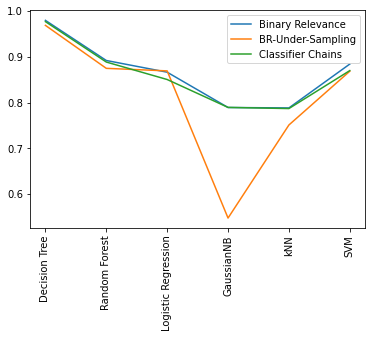

In [80]:
plt.plot(list(br_clf_accuracies.keys()), list(br_clf_accuracies.values()))
plt.plot(list(br_clfus_accuracies.keys()), list(br_clfus_accuracies.values()))
plt.plot(list(cc_accuracies.keys()), list(cc_accuracies.values()))
plt.xticks(rotation=90)
plt.legend(['Binary Relevance','BR-Under-Sampling', 'Classifier Chains'])

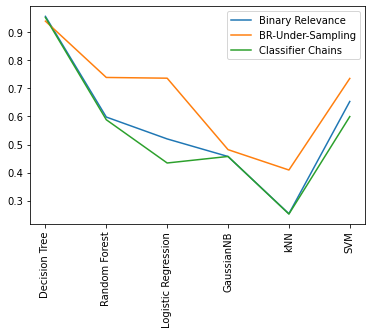

In [81]:
plt.plot(list(br_clf_f1.keys()), list(br_clf_f1.values()))
plt.plot(list(br_clfus_f1.keys()), list(br_clfus_f1.values()))
plt.plot(list(cc_f1.keys()), list(cc_f1.values()))
plt.xticks(rotation=90)
plt.legend(['Binary Relevance','BR-Under-Sampling', 'Classifier Chains'])
